# Solute Transport
<p>This is a second attempt at the solute transport notebook. I'm not sure what happened to the first one, but I guess it's not really working anymore. I didn't really get too far into it so that's ok.</p>


<p>In this notebook, I hope to outline a method to model solute transport, including advection, diffusion, and dispersion. Solute/contaminant transport in an aquifer occurs by the combination of those three methods.</p>
<p><b>Advection</b> is the process by which solute is carried along by the bulk motion of the fluid</p>
<p><b>Diffusion</b> is the <u>microscopic</u> random motion of solute particles in the water.</p>
<p><b>Dispersion</b> is the <u>macroscopic</u> process by which solute spreads out due to nonideal flow conditions. Solute can disperse longitudinall, transversely, and vertically.</p>
<p>The general equation that we use for solute transport modelling is the <b>Advection-Dispersion Relation (ADR) Equation:</b></p>
<h3><center>$\frac{\partial C}{\partial t} = D_{x} \frac{\partial^{2} C}{\partial x^{2}} + D_{y} \frac{\partial^{2} C}{\partial y^{2}} + D_{z} \frac{\partial^{2} C}{\partial z^{2}} - v \frac{\partial C}{\partial x} - \lambda RC$</center></h3>

## A solute transport model
<p>I'll try to keep the model as simple as I can. To model tracer transport first with advection, I just need a second queue to monitor the concentration and amount of tracer in each element, which will then be carried by the motion of the water. For now, a 1D model will do.</p>
<p>In this first function, the term we are concerned with is $v \frac{\partial C}{\partial x}$, which is the advective term, where $v$ is groundwater velocity and $C$ is solute concentration.</p>
<p>This equation shouldn't be too hard to work with. $\frac{\partial C}{\partial x}$ is just equal to the difference in the concentration of two adjacent cells. The velocity $v$ can be determined just using the Darcy velocity and the porosity</p>
<p>It would probably be a good idea to use the queue as an intermediate in order to determine average velocity: $\bar{u} = \frac{q}{\theta}$</p>

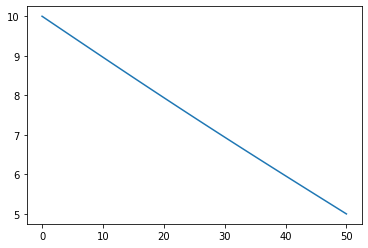

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

def steadyStateUpdate(heads,queue,conductivity):
    queue[:-1] += (heads[1:] - heads[:-1])*conductivity
    queue[1:] += (heads[:-1] - heads[1:])*conductivity
    
    heads += queue
    
    return heads

def steadyStateHeads(heads,queue,conductivity):
    queue = np.zeros(queue.size)
    queue[:-1] += (heads[1:] - heads[:-1])*conductivity
    queue[1:] += (heads[:-1] - heads[1:])*conductivity
    
    return queue
    
length = 51
    
heads = np.full(length,5.0)
heads[0] = 10
heads[-1] = 5
queue = np.zeros(length)

for i in range(10000):
    queue = np.zeros(length)
    heads = steadyStateUpdate(heads,queue,.1)
    heads[0] = 10
    heads[-1] = 5
    '''
    if heads[50] <= 0:
        heads[50] = 0
    else:
        heads[50] -= .3
    '''
plt.plot(heads)
plt.show()

### Some Analysis
<p>From this example, with some constant boundary conditions, the hydraulic head will evolve to be linear. This makes the equation for $\frac{\partial C}{\partial x}$ pretty easy to determine because it's a constant. It will be the slope of the equation.</p>
<p>However, this model makes a pretty difficult assumption. It assumes that the area that the discharge passes through is equal to 1. For this condition to be true, the aquifer must be confined and have a constant height throughout, so that the head differences are due to pressure differences along the aquifer. This isn't impossible, it just means that this model cannot be used for unconfined aquifers. As for some values, it assumes that the flow area is 1, as I have not put any dimensions in the function. That will suffice for now.</p>
<p>Actually, the assumption that the aquifer is confined and that the flow area is constant makes things a bit easier: Darcy velocity is equal to discharge divided by flow area, but our function is already equal to the normalized value. So, I don't have to change any values. At steady state, all of the queue values should be zero, as the water flowing into and out of each cell is equal. Therefore, the velocity of the water into and out of each cell should be equal. The velocity of the water can be determined by:</p>
<h3><center>$v = \frac{q}{\theta}$</center></h3>
<p>For my dataset, I'll just take the average value of $q$ to use for this, which should be constant among each element. I'll use a $\theta$ value of .25.</p>

In [15]:
porosity = .25
averageQ = np.average(queue[1:-1])  # Excluding the first and last values
avgVelocity = averageQ/porosity
avgVelocity *= 100

print("The average velocity of the water through each element is {}".format(round(avgVelocity,7)))

The average velocity of the water through each element is 0.0063004


<p>I will start with advection because it is the simplest. For advection, I really just need to keep track of the velocity. A solute plume will stay mostly as a cohesive group under ONLY the influence of advection. To determine this, I need the average velocity over the array. For now, I'll use the steady state model where the groundwater velocity is constant throughout the model and just use a single value of velocity.</p>
<h3><center>$ \bar{u} = \frac{q}{\theta} = \frac{K}{\theta} \frac{dh}{dx}$</center></h3>

<h3>How the advection function will work</h3>
<p>Basically, I need to track how far a single point would move in the system in a single timeDelta step. Using that, I determine how much solute flows out of a single element at one time step and how much would flow in by using the ratio of distance travelled to element scale.</p>

In [122]:
import numpy as np
import matplotlib.pyplot as plt

def averageVelocity(heads, conductivity, porosity, scale):
    q = (conductivity/scale) * (heads[:-1] - heads[1: ])
    avgVelocity = abs(np.sum(q))/porosity
    return avgVelocity

    
def advection(concentrations, avgVelocity, timeDelta, scale, carryOver):
    distanceTravelled = avgVelocity * timeDelta
    adjusted = distanceTravelled/scale
    carryOver += adjusted
    if carryOver >= 1:
        change = int(carryOver // 1)
        #print("Change: {}".format(change))
        concChanges = np.round(np.copy(concentrations[:-change]),3)
        #print("concChanges: {}".format(concChanges))
        concentrations[:-change] -= concChanges
        concentrations[change:] += concChanges
        carryOver -= change
        del concChanges
    return carryOver


In [94]:
scale = 1
heads = np.linspace(1,0,11)
concentrations = np.zeros(11)
concentrations[0] = 1
conductivity = .1
porosity = .25
avgVelocity = averageVelocity(heads, conductivity, porosity, scale)
timeDelta = 1
carryOver = 0


In [95]:
avgVelocity = .5

for i in range(10):
    carryOver = advection(concentrations, avgVelocity, timeDelta, scale, carryOver)

print("Total concentration in system: {}".format(np.sum(concentrations)))

Total concentration in system: 1.0


### Plotting

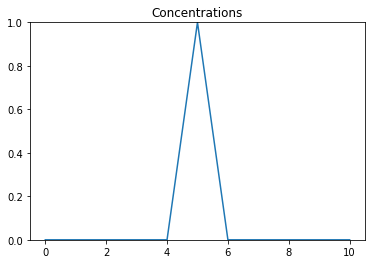

In [96]:
plt.plot(concentrations)
plt.title("Concentrations")
plt.ylim(0,1)
plt.show()

## Analysis
<p>The advection function works just fine. The only issue is that it requires a carryOver variable. Additionally, the average velocity must be the same at every point. I haven't figured out yet how to use a differential velocity over the model. It does conserve the total solute in the system, though.</p>
<p>Now, I need a function for diffusion. This isn't too hard, I don't think. I think I can just use a fraction for how much solute wanders out of an element.</p>

In [128]:
def diffusion(concentrations, diffusivity, timeDelta):
    adjusted = np.round(np.copy(concentrations*diffusivity*timeDelta),3)
    concentrations[1:-1] -= 2*adjusted[1:-1]
    concentrations[0] -= adjusted[0]
    concentrations[-1] -= adjusted[-1]
    concentrations[1: ] += adjusted[:-1]
    concentrations[:-1] += adjusted[1: ]
    del adjusted


In [124]:
diffusivity = .05
diffusion(concentrations, diffusivity, timeDelta)

Sum of concentrations: 0.903


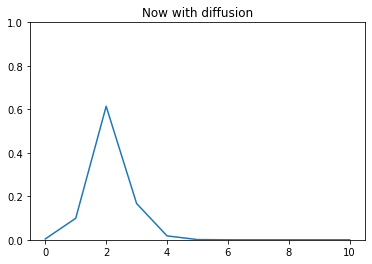

In [129]:
print('Sum of concentrations: {}'.format(np.sum(concentrations)))
plt.plot(concentrations)
plt.title("Now with diffusion")
plt.ylim(0,1)
plt.show()

## Now, a test together

In [131]:
concentrations = np.zeros(11)
concentrations[0] = 1
carryOver = 0

for i in range(105):
    diffusion(concentrations, diffusivity, timeDelta)
    carryOver = advection(concentrations, avgVelocity, timeDelta, scale, carryOver)
    
print("Total solute in system:",np.sum(concentrations))

Total solute in system: 0.999999999999996


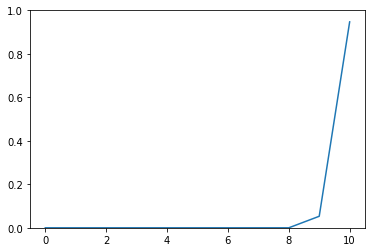

In [132]:
plt.plot(concentrations)
plt.ylim(0,1)
plt.show()

## Model Analysis
<p>Originally, there was a problem with some of the solute getting lost at the edges, but I figured that out now. I was double counting the edges, so any in the edge was being removed twice, and therefore not being conserved. It totally works and conserves everything now.</p>  